In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    

import preprocess as pp

import os.path as osp
import os
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "white"

In [5]:
REF_DIR = "/home/alma/w-projects/ccf/rsc/ref/hippo"

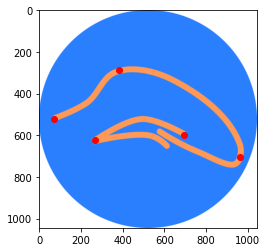

In [6]:
ref_img = Image.open(osp.join(REF_DIR,"hippo-ref.png"))
ref_lmk = pd.read_csv(osp.join(REF_DIR,"hippo-reference_landmarks.tsv"),sep="\t",header = 0,index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_coord,ref_lmk.y_coord,c = "red")


In [7]:
grid_crd,mta = pp.reference_to_grid(ref_img,n_approx_points=1000)

[0 2]


In [8]:
n_lmk = ref_lmk.shape[0]
lmk_cmap = {0:"blue",1:"red",2:"green",3:"yellow",4:"magenta"}

In [9]:
ref_lmk

,x_coord,y_coord
Landmark_0,72.105,521.455
Landmark_1,383.515,284.240
Landmark_2,963.490,702.240
Landmark_3,267.520,624.910
Landmark_4,697.015,596.695


In [12]:
mta_cmap = {0:"lightgray",1:"blue"}

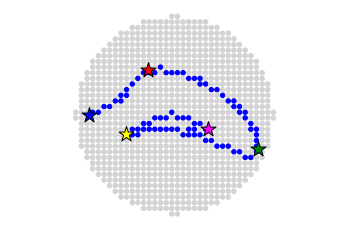

In [13]:
plt.scatter(grid_crd[:,0],grid_crd[:,1],c = [mta_cmap[x] for x in mta],s = 20)
plt.axis("equal")
plt.axis("off")
for ii in range(n_lmk):
    plt.scatter(ref_lmk.x_coord.values[ii],
                ref_lmk.y_coord.values[ii],
                c = lmk_cmap[ii],
                marker = "*",
                edgecolor ="black",
                s = 250,
               )

plt.gca().invert_yaxis()
plt.show()

In [14]:
import models as m
import methods as f
import gpytorch as gp

ref = m.Reference(grid_crd,
                  landmarks = ref_lmk.values,
                  meta = dict(region = mta)
                 )

/home/alma/w-projects/ccf/src/models.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.landmarks = t.tensor(landmarks)
/home/alma/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
VIS_PTH = "/home/alma/w-projects/ccf/data/visium-hippo/hippo-only.h5ad"
SS_PTH ="/home/alma/w-projects/ccf/data/slideseq-hippo/Puck_200115_08/curated/Puck_200115_08.h5ad"


In [16]:
adata_1= ad.read_h5ad(VIS_PTH)
adata_2 = ad.read_h5ad(SS_PTH)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
sc.pp.filter_cells(adata_2,min_counts=100)

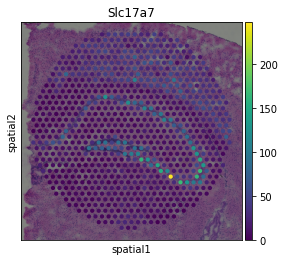

In [18]:
sc.pl.spatial(adata_1,color="Slc17a7")

In [ ]:
adatas = [adata_1,adata_2]
for adata in adatas:
    sc.pp.filter_genes(adata,min_cells = 0.1)
    #sc.pp.normalize_total(adata,1e4,
    #                      exclude_highly_expressed = True)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    pp.match_scales(adata,ref_lmk.values)
    pp.get_landmark_distance(adata,
                             reference=ref_lmk.values)    



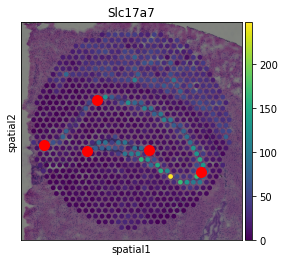

In [20]:
sf = adata_1.uns["spatial"]["V1_Adult_Mouse_Brain"]["scalefactors"]["tissue_hires_scalef"]
ax = sc.pl.spatial(adata_1,color="Slc17a7",spot_size = 100,return_fig=True,show=False)
ax[0].scatter(adata_1.uns["curated_landmarks"][:,0] * sf,
              adata_1.uns["curated_landmarks"][:,1] * sf,
              c = "red",
              s = 100,
             alpha = 1,
             )
plt.show()

In [21]:
lmk_cmap = {0:"blue",1:"red",2:"green",3:"yellow",4:"magenta"}

In [22]:
n_lmk = adata_1.uns["curated_landmarks"].shape[0]

In [23]:
rgba = np.zeros((adata_1.shape[0],4))
rgba[:,-1] = adata_1.obs_vector("Slc17a7")
rgba[:,-1] -= rgba[:,-1].min()
rgba[:,-1] /= rgba[:,-1].max()
rgba[:,-1] *= 0.7
rgba[:,2] = 1

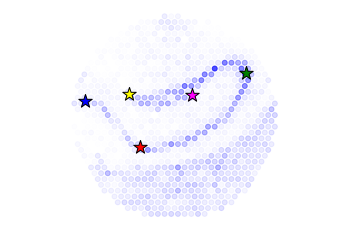

In [24]:
plt.scatter(adata_1.obsm["spatial"][:,0],
            adata_1.obsm["spatial"][:,1],
            c = rgba,
            #alpha = 1,
            s = 25,
           # cmap = plt.cm.viridis,
           )

for ii in range(n_lmk):
    plt.scatter(adata_1.uns["curated_landmarks"][ii,0],
                adata_1.uns["curated_landmarks"][ii,1],
                c = lmk_cmap[ii],
                marker = "*",
                edgecolor ="black",
                s = 200,
               )
plt.axis("equal")
plt.axis("off")
plt.show()

In [ ]:
keep = np.random.choice(adata_2.shape[0],replace =False,size = int(adata_2.shape[0]*0.1))
adata_2 = adata_2[keep,:]
adata_2.shape

In [25]:
rgba = np.zeros((adata_2.shape[0],4))
rgba[:,-1] = adata_2.obs_vector("Slc17a7")
rgba[:,-1] -= rgba[:,-1].min()
rgba[:,-1] /= rgba[:,-1].max()
rgba[:,-1] *= 0.1
rgba[:,2] = 1

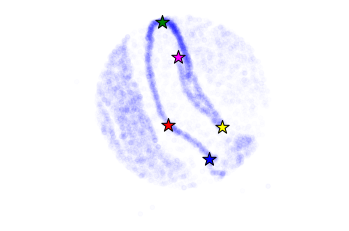

In [26]:
plt.scatter(adata_2.obsm["spatial"][:,0],
            adata_2.obsm["spatial"][:,1],
            c = rgba,
            #alpha = 0.5,
            s = 20,
            #cmap = plt.cm.viridis,
           )
for ii in range(n_lmk):
    plt.scatter(adata_2.uns["curated_landmarks"][ii,0],
                adata_2.uns["curated_landmarks"][ii,1],
                c = lmk_cmap[ii],
                marker = "*",
                edgecolor ="black",
                s = 200,
               )
plt.axis("equal")
plt.axis("off")
plt.show()

In [ ]:
adata_1.write

In [ ]:
import torch as t

In [ ]:
adatas = [adata_1,adata_2]
models = f.map_to_reference(adatas,
                            "Slc17a7",
                            ref,
                            n_epochs=50,
                            device ="cuda",
                           )
%time

In [ ]:
import utils as ut

In [ ]:
ut.spatial_smoothing(ref.adata)

In [ ]:
ref.plot(spot_size=35,cmap = plt.cm.Blues)#,ncols = 5)